PS: this code was copied "as it was" from [here][1]. Obviously, it is not configured and the notebook output are not correct. See the beforementioned link for more details.

[1]: https://stanford.edu/~boyd/papers/prox_algs/control.html


In [1]:
function h = control

Continuation prompt found - input was incomplete:
function h = control


## Problem data

In [2]:
s = RandStream.create('mt19937ar','seed',0);
RandStream.setDefaultStream(s);

n = 50; % decision variables
m = 5;  % PWL components

A = randn(m,4*n,8);
b = randn(m,1);

f = @(u,A) max(A*u(:) + b);

error: 'RandStream' undefined near line 1, column 1

The 'RandStream' function is not yet implemented in Octave.

Please read <https://www.octave.org/missing.html> to learn how you can
contribute missing functionality.
error: 'RandStream' undefined near line 1, column 1

The 'RandStream' function is not yet implemented in Octave.

Please read <https://www.octave.org/missing.html> to learn how you can
contribute missing functionality.


## CVX

In [3]:
tic
cvx_begin quiet
    variables y_aaa(n,4) y_aab(n,4) y_aba(n,4) y_abb(n,4) ...
              y_baa(n,4) y_bab(n,4) y_bba(n,4) y_bbb(n,4);
    obj = f(y_aaa,A(:,:,1)) + f(y_aab,A(:,:,2)) + f(y_aba,A(:,:,3)) + f(y_abb,A(:,:,4)) + ...
          f(y_baa,A(:,:,5)) + f(y_bab,A(:,:,6)) + f(y_bba,A(:,:,7)) + f(y_bbb,A(:,:,8));
    minimize(obj);
    subject to

        % all initial actions must agree
        y_aaa(:,1) == y_aab(:,1);
        y_aab(:,1) == y_aba(:,1);
        y_aba(:,1) == y_abb(:,1);
        y_abb(:,1) == y_baa(:,1);
        y_baa(:,1) == y_bab(:,1);
        y_bab(:,1) == y_bba(:,1);
        y_bba(:,1) == y_bbb(:,1);

        y_aaa(:,2) == y_aab(:,2);
        y_aab(:,2) == y_aba(:,2);
        y_aba(:,2) == y_abb(:,2);

        y_baa(:,2) == y_bab(:,2);
        y_bab(:,2) == y_bba(:,2);
        y_bba(:,2) == y_bbb(:,2);

        y_aaa(:,3) == y_aab(:,3);
        y_aba(:,3) == y_abb(:,3);
        y_baa(:,3) == y_bab(:,3);
        y_bba(:,3) == y_bbb(:,3);

        y_aaa <= 1;
        y_aab <= 1;
        y_aba <= 1;
        y_abb <= 1;
        y_baa <= 1;
        y_bab <= 1;
        y_bba <= 1;
        y_bbb <= 1;

        y_aaa >= -1;
        y_aab >= -1;
        y_aba >= -1;
        y_abb >= -1;
        y_baa >= -1;
        y_bab >= -1;
        y_bba >= -1;
        y_bbb >= -1;
cvx_end
toc

h.p_cvx = cvx_optval/8;

% Prescient solution
cvx_begin quiet
    variables w_aaa(n,4) w_aab(n,4) w_aba(n,4) w_abb(n,4) ...
              w_baa(n,4) w_bab(n,4) w_bba(n,4) w_bbb(n,4);
    obj = f(w_aaa,A(:,:,1)) + f(w_aab,A(:,:,2)) + f(w_aba,A(:,:,3)) + f(w_abb,A(:,:,4)) + ...
          f(w_baa,A(:,:,5)) + f(w_bab,A(:,:,6)) + f(w_bba,A(:,:,7)) + f(w_bbb,A(:,:,8));
    minimize(obj);
    subject to
        w_aaa <= 1;
        w_aab <= 1;
        w_aba <= 1;
        w_abb <= 1;
        w_baa <= 1;
        w_bab <= 1;
        w_bba <= 1;
        w_bbb <= 1;
        w_aaa >= -1;
        w_aab >= -1;
        w_aba >= -1;
        w_abb >= -1;
        w_baa >= -1;
        w_bab >= -1;
        w_bba >= -1;
        w_bbb >= -1;
cvx_end

h.p_cvx_pres = cvx_optval/8;

error: 'cvx_begin' undefined near line 1, column 1
error: 'variables' undefined near line 1, column 1
error: 'y_aaa' undefined near line 1, column 1
error: 'obj' undefined near line 1, column 1
error: 'subject' undefined near line 1, column 1
error: 'y_aaa' undefined near line 1, column 1
error: 'y_aab' undefined near line 1, column 1
error: 'y_aba' undefined near line 1, column 1
error: 'y_abb' undefined near line 1, column 1
error: 'y_baa' undefined near line 1, column 1
error: 'y_bab' undefined near line 1, column 1
error: 'y_bba' undefined near line 1, column 1
error: 'y_aaa' undefined near line 1, column 1
error: 'y_aab' undefined near line 1, column 1
error: 'y_aba' undefined near line 1, column 1
error: 'y_baa' undefined near line 1, column 1
error: 'y_bab' undefined near line 1, column 1
error: 'y_bba' undefined near line 1, column 1
error: 'y_aaa' undefined near line 1, column 1
error: 'y_aba' undefined near line 1, column 1
error: 'y_baa' undefined near line 1, column 1
error

## ADMM

In [4]:
MAX_ITER = 100;
ABSTOL   = 1e-4;
RELTOL   = 1e-2;

lambda = 1;

x_aaa = zeros(n,4); x_aab = zeros(n,4); x_aba = zeros(n,4); x_abb = zeros(n,4);
x_baa = zeros(n,4); x_bab = zeros(n,4); x_bba = zeros(n,4); x_bbb = zeros(n,4);

z_0   = zeros(n,1);
z_a   = zeros(n,1); z_b   = zeros(n,1);
z_aa  = zeros(n,1); z_ab  = zeros(n,1); z_ba  = zeros(n,1); z_bb  = zeros(n,1);
z_aaa = zeros(n,4); z_aab = zeros(n,4); z_aba = zeros(n,4); z_abb = zeros(n,4);
z_baa = zeros(n,4); z_bab = zeros(n,4); z_bba = zeros(n,4); z_bbb = zeros(n,4);
z = [ z_aaa z_aab z_aba z_abb z_baa z_bab z_bba z_bbb ];

u_aaa = zeros(n,4); u_aab = zeros(n,4); u_aba = zeros(n,4); u_abb = zeros(n,4);
u_baa = zeros(n,4); u_bab = zeros(n,4); u_bba = zeros(n,4); u_bbb = zeros(n,4);

tstart = tic;
tx = 0;

for k = 1:MAX_ITER

    % x-update
    titer = tic;
    x_aaa = prox_f(z_aaa - u_aaa, lambda, A(:,:,1), b);
    x_aab = prox_f(z_aab - u_aab, lambda, A(:,:,2), b);
    x_aba = prox_f(z_aba - u_aba, lambda, A(:,:,3), b);
    x_abb = prox_f(z_abb - u_abb, lambda, A(:,:,4), b);
    x_baa = prox_f(z_baa - u_baa, lambda, A(:,:,5), b);
    x_bab = prox_f(z_bab - u_bab, lambda, A(:,:,6), b);
    x_bba = prox_f(z_bba - u_bba, lambda, A(:,:,7), b);
    x_bbb = prox_f(z_bbb - u_bbb, lambda, A(:,:,8), b);
    tx = tx + toc(titer);

    % z-update
    % Note: should strictly be x + u, but u's sum to zero, so are omitted.
    z_0 = avg(x_aaa(:,1), x_aab(:,1), x_aba(:,1), x_abb(:,1), ...
              x_baa(:,1), x_bab(:,1), x_bba(:,1), x_bbb(:,1));

    z_a = avg(x_aaa(:,2), x_aab(:,2), x_aba(:,2), x_abb(:,2));
    z_b = avg(x_baa(:,2), x_bab(:,2), x_bba(:,2), x_bbb(:,2));

    z_aa = avg(x_aaa(:,3), x_aab(:,3));
    z_ab = avg(x_aba(:,3), x_abb(:,3));
    z_ba = avg(x_baa(:,3), x_bab(:,3));
    z_bb = avg(x_bba(:,3), x_bbb(:,3));

    z_aaa = [z_0 z_a z_aa x_aaa(:,4)];
    z_aab = [z_0 z_a z_aa x_aab(:,4)];
    z_aba = [z_0 z_a z_ab x_aba(:,4)];
    z_abb = [z_0 z_a z_ab x_abb(:,4)];
    z_baa = [z_0 z_b z_ba x_baa(:,4)];
    z_bab = [z_0 z_b z_ba x_bab(:,4)];
    z_bba = [z_0 z_b z_bb x_bba(:,4)];
    z_bbb = [z_0 z_b z_bb x_bbb(:,4)];

    % u-update
    u_aaa = u_aaa + x_aaa - z_aaa;
    u_aab = u_aab + x_aab - z_aab;
    u_aba = u_aba + x_aba - z_aba;
    u_abb = u_abb + x_abb - z_abb;
    u_baa = u_baa + x_baa - z_baa;
    u_bab = u_bab + x_bab - z_bab;
    u_bba = u_bba + x_bba - z_bba;
    u_bbb = u_bbb + x_bbb - z_bbb;

    % diagnostics, reporting, termination checks
    x = [ x_aaa x_aab x_aba x_abb x_baa x_bab x_bba x_bbb ];
    zold = z;
    z = [ z_aaa z_aab z_aba z_abb z_baa z_bab z_bba z_bbb ];
    u = [ u_aaa u_aab u_aba u_abb u_baa u_bab u_bba u_bbb ];

    h.r_norm(k)   = norm(x - z,'fro');
    h.s_norm(k)   = norm(-(z - zold)/lambda,'fro');
    h.eps_pri(k)  = sqrt(numel(x))*ABSTOL + RELTOL*max(norm(x,'fro'), norm(-z,'fro'));
    h.eps_dual(k) = sqrt(numel(x))*ABSTOL + RELTOL*norm(u/lambda,'fro');

    h.objval(k)   = (1/8)*(f(z_aaa,A(:,:,1)) + f(z_aab,A(:,:,2)) + f(z_aba,A(:,:,3)) + ...
                           f(z_abb,A(:,:,4)) + f(z_baa,A(:,:,5)) + f(z_bab,A(:,:,6)) + ...
                           f(z_bba,A(:,:,7)) + f(z_bbb,A(:,:,8)));

    if mod(k,10) == 0
        fprintf('%3d\t%10.4f\t%10.4f\t%10.4f\t%10.4f\n', k, ...
            h.r_norm(k), h.eps_pri(k), h.s_norm(k), h.eps_dual(k));
    end

    if h.r_norm(k) < h.eps_pri(k) && h.s_norm(k) < h.eps_dual(k)
         break;
    end

end

tx/k
toc(tstart)

error: 'prox_f' undefined near line 5, column 5
ans = 0
Elapsed time is 0.114914 seconds.


## Plotting

error: 'h' undefined near line 1, column 1
error: 'h' undefined near line 1, column 1
error: 'h' undefined near line 1, column 1


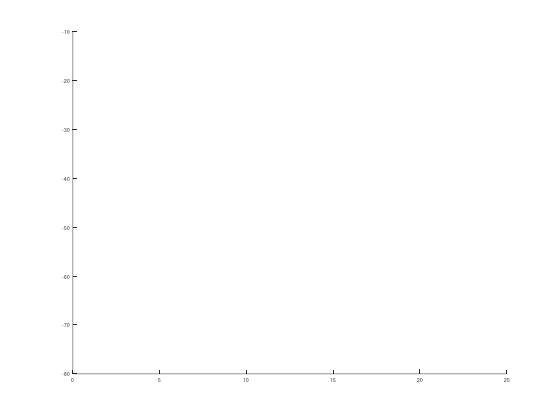

In [5]:
figure(1);

% objective convergence (evaluated with z^k)
hold on;
plot(h.objval);
plot(repmat(h.p_cvx,k,1), 'k--');
plot(repmat(h.p_cvx_pres,k,1), 'k--');
hold off;
xlim([0 25]);
ylim([-80 -10]);
print -depsc ctrl_progress.eps;

In [6]:
end

function x = avg(varargin)
    N = length(varargin);
    x = 0;
    for k = 1:N
        x = x + varargin{k};
    end
    x = x/N;
end

function x = prox_f(v, lambda, A, b)
% CVXGEN-based solver.
    [n T] = size(v);
    params.A_0 = A(:,1:n);
    params.A_1 = A(:,n+1:2*n);
    params.A_2 = A(:,2*n+1:3*n);
    params.A_3 = A(:,3*n+1:4*n);
    params.lambda = lambda;
    params.b   = b;
    params.v_0 = v(:,1);
    params.v_1 = v(:,2);
    params.v_2 = v(:,3);
    params.v_3 = v(:,4);
    settings.verbose = 0;
    vars = csolve(params, settings);
    x = [vars.x_0 vars.x_1 vars.x_2 vars.x_3];
end

function x = prox_f_cvx(v, lambda, f, A)
% For testing purposes.
    [n T] = size(v);
    cvx_begin quiet
        variable x(n,T)
        minimize(f(x,A) + (1/(2*lambda))*square_pos(norm(x - v,'fro')))
        subject to
            x <= 1;
            x >= -1;
    cvx_end
end

error: parse error:

  syntax error

>>> end
      ^
